# Section 2
In this section of tutorial, you will:
1. Load an unlabeled dataset
2. Examine the distribution of classifier scores
3. Select a data sample for getting the oracle labels (e.g., send for human annotation)
4. Select a data sample by two different ways: random, uniform on C(X)
    * Construct three representations of the joint distribution for the data sample generated by different sampling stratgy
    * Obtain a calibration curve from the labeled data sample in two ways: Nonparametric binning and Platt scaling
    * Estimate the prevalence of the original unlabeled dataset using a calibration curve learned from the labeled data sample
    * Generating confidence interval estimation by bootstrapping the labeled data sample

For the exercises, we ask you to rerun this code on a different dataset and answer the following questions:
1. What’s the method call to get the ground truth labels?
2. With 5000 labels randomly sampled…
    * What is the fraction of ground truth positive in the sample?
    * What is the estimated fraction of ground truth positive for the whole 100K?
    * What is the actual fraction of ground truth positive labels for the whole 100K?
    * How close are these to each other and why are they not exactly the same?
    * How big is the 95% confidence interval around estimated GT?
3. With 5000 labels uniformly sampled according to C(X)...
    * What is the fraction of ground truth positive in the sample?
    * What is the estimated fraction of ground truth positive for the whole 100K?
    * What is the actual fraction of ground truth positive labels for the whole 100K?
    * How close are these to each other and why are they not exactly the same?
    * How big is the 95% confidence interval around estimated GT?
4. Looking at the grid of results representation, what are key differences between random sampling and uniform sampling?
5. Fill in columns D and E rows 6-13

You should also fill in column E and F for dataset 2 in your copy of the [results spreadsheet]( https://docs.google.com/spreadsheets/d/10oEQR-_6px9sRF3cRiIPChiBcrWPVPy12TN7oHCA4qU), based on your findings from the notebook.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from util import plot_stacked_frequency
from util import DataHandler, NPBinningCalibrationCurve, LogisticCalibrationCurve, ProbabilityEstimator

## 1. Load an unlabeled dataset

In [2]:
# base is a very large dataset
base_dh = DataHandler('data/dataset1_base.csv')

In [3]:
# TODO: change the dataset to 'data/dataset1_target.csv'
# base_dh = DataHandler('data/dataset1_target.csv')

In [4]:
# you observe only classifier scores C(X), but no GT labels
base_dh.observed_df

,C(X),GT
0,0.254796,
1,0.888630,
2,0.815468,
3,0.801820,
4,0.209585,
...,...,...
99995,0.383462,
99996,0.937050,
99997,0.066808,
99998,0.358555,


In [5]:
# count_gt() function returns the number of items with GT labels
base_dh.count_gt()

0

## 2. distribution of classifier scores

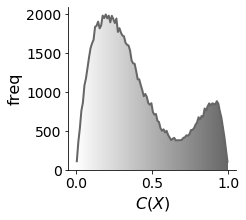

In [6]:
base_dh.plot_dist_classifier_scores()

## 3. Assume that we have some budget to obtain the GT labels

In [7]:
# the `get_oracle_labels` function will get the GT labels for specifc rows
base_dh.get_oracle_labels(rows=[0, 1, 2])

In [8]:
base_dh.observed_df

,C(X),GT
0,0.254796,False
1,0.888630,True
2,0.815468,True
3,0.801820,
4,0.209585,
...,...,...
99995,0.383462,
99996,0.937050,
99997,0.066808,
99998,0.358555,


In [9]:
# we can also get a subset of all labeled rows
base_dh.sample_df

,C(X),GT
0,0.254796,False
1,0.888630,True
2,0.815468,True


## 4. Different ways of sampling and distribution profiles: Random sampling

In [10]:
base_dh.hide_all_oracle()

In [11]:
sampeld_rows = base_dh.get_sample_for_labeling(n_item=5000, strategy='random')

In [12]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [13]:
base_dh.count_gt()

5000

In [14]:
base_dh.sample_df

,C(X),GT
5,0.186483,False
29,0.636424,True
74,0.279076,False
103,0.672510,True
120,0.269125,False
...,...,...
99907,0.356404,False
99923,0.131296,False
99924,0.807168,True
99933,0.919525,True


In [15]:
random_sample_df = base_dh.sample_df

In [16]:
random_sample_df.shape

(5000, 2)

### 4.1. Joint Distributions of the Random Labeled Sample

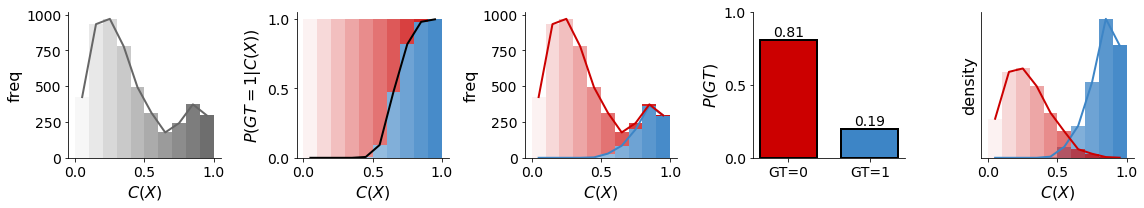

In [17]:
base_dh.generate_all_distribution_plots(df=random_sample_df, num_bin=10)

### 4.2 Obtain a Calibration Curve

#### 4.2.1. Nonparametric binning calibration curve

In [18]:
sample_calibration_curve = NPBinningCalibrationCurve(random_sample_df, num_bin=10)

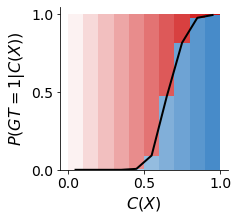

In [19]:
sample_calibration_curve.plot()

#### 4.2.1. Logistic regression calibration curve

In [20]:
sample_calibration_curve = LogisticCalibrationCurve()
sample_calibration_curve.fit(random_sample_df)

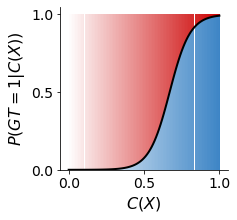

In [21]:
sample_calibration_curve.plot()

### 4.3 Estimate the prevalence of the original unlabeled dataset using a calibration curve learned from the labeled data sample

#### 4.3.1. With a Nonparametric binning calibration curve

In [22]:
pe_estimator = ProbabilityEstimator()

sample_calibration_curve = NPBinningCalibrationCurve(random_sample_df, num_bin=10)
pe_estimator.set_calibration_curve(sample_calibration_curve)

input_cx_array = base_dh.observed_df['C(X)'].values

pe_estimator.estimate(input_cx_array)

0.20036951055159397

#### 4.3.2 With a LogisticCalibrationCurve

In [23]:
pe_estimator = ProbabilityEstimator()

sample_calibration_curve = LogisticCalibrationCurve()
sample_calibration_curve.fit(random_sample_df)
pe_estimator.set_calibration_curve(sample_calibration_curve)

input_cx_array = base_dh.observed_df['C(X)'].values

pe_estimator.estimate(input_cx_array)

0.19971511666548883

### 4.4 Obtaining confidence intervals by Bootstrap sampling the labeled sample

In [24]:
def bootstrap_estimating(input_cx_array, df, num_bootstrap, calibration_curve='platt scaling', verbose=False):
    pe_estimator = ProbabilityEstimator()

    estimated_result_list = []

    for bootstrap_idx in range(num_bootstrap):
        n_item = len(df)
        bootstrapped_sample_df = df.sample(frac=1, replace=True)

        if calibration_curve == 'platt scaling':
            bootstrapped_calibration_curve = LogisticCalibrationCurve()
            bootstrapped_calibration_curve.fit(bootstrapped_sample_df)
        elif calibration_curve == 'nonparametric binning':
            bootstrapped_calibration_curve = NPBinningCalibrationCurve(bootstrapped_sample_df, num_bin=10)

        pe_estimator.set_calibration_curve(bootstrapped_calibration_curve)

        bootstrapped_pe_estimation = pe_estimator.estimate(input_cx_array)
        if verbose:
            print(f'bootstrap {bootstrap_idx+1:>3}: {bootstrapped_pe_estimation:.4f}')
        estimated_result_list.append(bootstrapped_pe_estimation)    
    return estimated_result_list

#### 4.4.1 Use random sample to make estimation with PE estimator

In [25]:
npbin_estimated_result_list = bootstrap_estimating(base_dh.observed_df['C(X)'].values, 
                                                   random_sample_df, 
                                                   num_bootstrap=500, 
                                                   calibration_curve='nonparametric binning', 
                                                   verbose=True)

bootstrap   1: 0.1993
bootstrap   2: 0.1982
bootstrap   3: 0.2020
bootstrap   4: 0.1992
bootstrap   5: 0.1985
bootstrap   6: 0.2041
bootstrap   7: 0.1956
bootstrap   8: 0.2002
bootstrap   9: 0.2027
bootstrap  10: 0.2032
bootstrap  11: 0.1986
bootstrap  12: 0.1960
bootstrap  13: 0.1984
bootstrap  14: 0.2022
bootstrap  15: 0.2016
bootstrap  16: 0.2002
bootstrap  17: 0.1959
bootstrap  18: 0.1965
bootstrap  19: 0.1971
bootstrap  20: 0.2023
bootstrap  21: 0.1982
bootstrap  22: 0.1979
bootstrap  23: 0.1992
bootstrap  24: 0.2049
bootstrap  25: 0.2017
bootstrap  26: 0.2034
bootstrap  27: 0.1995
bootstrap  28: 0.2007
bootstrap  29: 0.1982
bootstrap  30: 0.2032
bootstrap  31: 0.1990
bootstrap  32: 0.2025
bootstrap  33: 0.1998
bootstrap  34: 0.2003
bootstrap  35: 0.2014
bootstrap  36: 0.2018
bootstrap  37: 0.1978
bootstrap  38: 0.1977
bootstrap  39: 0.2030
bootstrap  40: 0.1984
bootstrap  41: 0.2024
bootstrap  42: 0.2006
bootstrap  43: 0.2001
bootstrap  44: 0.2028
bootstrap  45: 0.2003
bootstrap 

bootstrap 375: 0.2016
bootstrap 376: 0.2011
bootstrap 377: 0.1991
bootstrap 378: 0.1994
bootstrap 379: 0.2012
bootstrap 380: 0.1967
bootstrap 381: 0.2049
bootstrap 382: 0.2026
bootstrap 383: 0.2003
bootstrap 384: 0.2023
bootstrap 385: 0.2020
bootstrap 386: 0.2013
bootstrap 387: 0.2001
bootstrap 388: 0.2042
bootstrap 389: 0.1977
bootstrap 390: 0.2030
bootstrap 391: 0.2018
bootstrap 392: 0.1973
bootstrap 393: 0.1981
bootstrap 394: 0.2029
bootstrap 395: 0.2038
bootstrap 396: 0.1993
bootstrap 397: 0.1990
bootstrap 398: 0.2022
bootstrap 399: 0.2008
bootstrap 400: 0.2043
bootstrap 401: 0.2045
bootstrap 402: 0.2020
bootstrap 403: 0.2019
bootstrap 404: 0.1992
bootstrap 405: 0.1998
bootstrap 406: 0.2000
bootstrap 407: 0.2025
bootstrap 408: 0.1973
bootstrap 409: 0.1996
bootstrap 410: 0.2015
bootstrap 411: 0.2034
bootstrap 412: 0.2019
bootstrap 413: 0.2033
bootstrap 414: 0.2007
bootstrap 415: 0.2038
bootstrap 416: 0.2010
bootstrap 417: 0.2019
bootstrap 418: 0.2016
bootstrap 419: 0.2040
bootstrap 

In [26]:
def get_median_CI(lst):
    return f'Median estimation is {np.median(lst):.3f}, CI95 is ({np.percentile(lst, 2.5):.3f}, {np.percentile(lst, 97.5):.3f})'

In [27]:
get_median_CI(npbin_estimated_result_list)

'Median estimation is 0.201, CI95 is (0.196, 0.204)'

#### 4.4.1 Use purposive sample to make estimation with PE estimator

In [28]:
ps_estimated_result_list = bootstrap_estimating(base_dh.observed_df['C(X)'].values, 
                                                random_sample_df, 
                                                num_bootstrap=500, 
                                                calibration_curve='platt scaling', 
                                                verbose=True)

bootstrap   1: 0.1983
bootstrap   2: 0.1975
bootstrap   3: 0.2025
bootstrap   4: 0.1997
bootstrap   5: 0.1950
bootstrap   6: 0.2009
bootstrap   7: 0.1989
bootstrap   8: 0.1994
bootstrap   9: 0.1974
bootstrap  10: 0.1993
bootstrap  11: 0.2029
bootstrap  12: 0.1985
bootstrap  13: 0.1980
bootstrap  14: 0.1969
bootstrap  15: 0.1979
bootstrap  16: 0.1983
bootstrap  17: 0.1990
bootstrap  18: 0.2007
bootstrap  19: 0.2002
bootstrap  20: 0.1995
bootstrap  21: 0.2011
bootstrap  22: 0.2069
bootstrap  23: 0.2037
bootstrap  24: 0.1988
bootstrap  25: 0.2029
bootstrap  26: 0.1985
bootstrap  27: 0.1986
bootstrap  28: 0.1998
bootstrap  29: 0.1997
bootstrap  30: 0.1982
bootstrap  31: 0.1989
bootstrap  32: 0.1978
bootstrap  33: 0.1997
bootstrap  34: 0.1978
bootstrap  35: 0.1977
bootstrap  36: 0.1994
bootstrap  37: 0.2032
bootstrap  38: 0.1971
bootstrap  39: 0.2030
bootstrap  40: 0.2037
bootstrap  41: 0.2044
bootstrap  42: 0.2004
bootstrap  43: 0.2024
bootstrap  44: 0.2001
bootstrap  45: 0.2016
bootstrap 

bootstrap 391: 0.2030
bootstrap 392: 0.2016
bootstrap 393: 0.1994
bootstrap 394: 0.1985
bootstrap 395: 0.1970
bootstrap 396: 0.2029
bootstrap 397: 0.1978
bootstrap 398: 0.1981
bootstrap 399: 0.1978
bootstrap 400: 0.1987
bootstrap 401: 0.1995
bootstrap 402: 0.2011
bootstrap 403: 0.1978
bootstrap 404: 0.1994
bootstrap 405: 0.2004
bootstrap 406: 0.2001
bootstrap 407: 0.2009
bootstrap 408: 0.2022
bootstrap 409: 0.1957
bootstrap 410: 0.2039
bootstrap 411: 0.2005
bootstrap 412: 0.1990
bootstrap 413: 0.2015
bootstrap 414: 0.2010
bootstrap 415: 0.2031
bootstrap 416: 0.1978
bootstrap 417: 0.1957
bootstrap 418: 0.2031
bootstrap 419: 0.1987
bootstrap 420: 0.1988
bootstrap 421: 0.2004
bootstrap 422: 0.1982
bootstrap 423: 0.1969
bootstrap 424: 0.2028
bootstrap 425: 0.1961
bootstrap 426: 0.1995
bootstrap 427: 0.1983
bootstrap 428: 0.2009
bootstrap 429: 0.1994
bootstrap 430: 0.1989
bootstrap 431: 0.1997
bootstrap 432: 0.2012
bootstrap 433: 0.1987
bootstrap 434: 0.1998
bootstrap 435: 0.1989
bootstrap 

In [29]:
get_median_CI(ps_estimated_result_list)

'Median estimation is 0.200, CI95 is (0.196, 0.204)'

## But random sampling is often undesired for the highly imbalanced social media data, so we switch to uniform sampling on C(X)

### 2.2 Uniform sampling on C(X)

check if uniform will give us a tighter confidence intervals

In [30]:
base_dh.hide_all_oracle()

In [31]:
base_dh.count_gt()

0

In [32]:
sampeld_rows = base_dh.get_sample_for_labeling(n_item=5000, strategy='uniform on C(X)')
# sampeld_rows = base_dh.get_sample_for_labeling(n_item=1000, strategy='neyman')

In [33]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [34]:
base_dh.count_gt()

5000

In [35]:
base_dh.sample_df

,C(X),GT
0,0.254796,False
1,0.888630,True
2,0.815468,True
3,0.801820,True
4,0.209585,False
...,...,...
13215,0.677874,False
13221,0.617350,True
13228,0.663543,False
13246,0.653422,False


In [36]:
purposive_sample_df = base_dh.sample_df

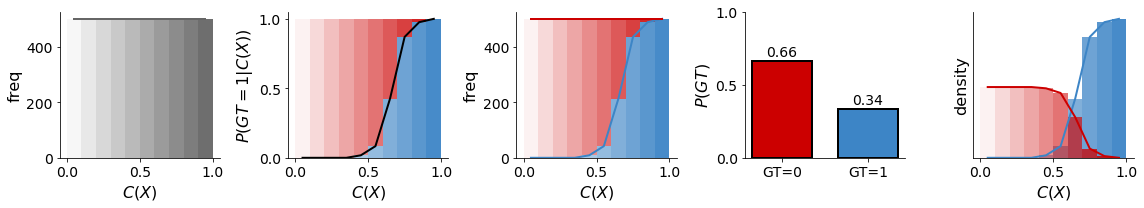

In [37]:
base_dh.generate_all_distribution_plots(df=purposive_sample_df, num_bin=10)

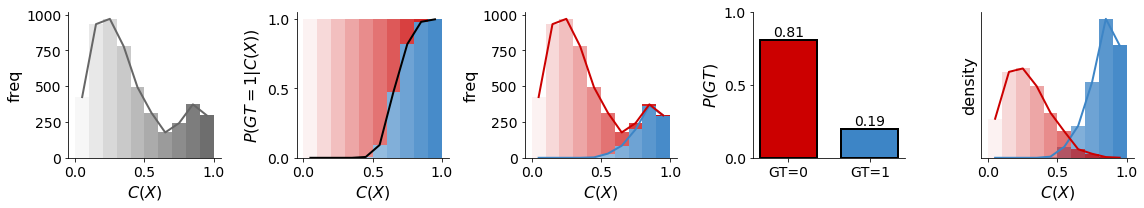

In [38]:
base_dh.generate_all_distribution_plots(df=random_sample_df, num_bin=10)

### What if we use a different sampling strategy?

In [39]:
npbin_estimated_result_list = bootstrap_estimating(base_dh.observed_df['C(X)'].values,
                                                   purposive_sample_df, 
                                                   num_bootstrap=500, 
                                                   calibration_curve='nonparametric binning', 
                                                   verbose=True)

bootstrap   1: 0.2019
bootstrap   2: 0.2036
bootstrap   3: 0.2033
bootstrap   4: 0.2013
bootstrap   5: 0.2024
bootstrap   6: 0.1996
bootstrap   7: 0.2021
bootstrap   8: 0.2021
bootstrap   9: 0.1979
bootstrap  10: 0.2030
bootstrap  11: 0.2045
bootstrap  12: 0.2006
bootstrap  13: 0.1997
bootstrap  14: 0.2008
bootstrap  15: 0.2007
bootstrap  16: 0.1991
bootstrap  17: 0.2025
bootstrap  18: 0.2035
bootstrap  19: 0.2008
bootstrap  20: 0.2033
bootstrap  21: 0.2017
bootstrap  22: 0.2017
bootstrap  23: 0.1999
bootstrap  24: 0.2044
bootstrap  25: 0.2006
bootstrap  26: 0.2007
bootstrap  27: 0.2037
bootstrap  28: 0.2038
bootstrap  29: 0.2004
bootstrap  30: 0.2007
bootstrap  31: 0.2024
bootstrap  32: 0.1983
bootstrap  33: 0.2036
bootstrap  34: 0.2037
bootstrap  35: 0.2023
bootstrap  36: 0.2036
bootstrap  37: 0.2003
bootstrap  38: 0.2011
bootstrap  39: 0.2009
bootstrap  40: 0.2036
bootstrap  41: 0.2006
bootstrap  42: 0.1992
bootstrap  43: 0.2045
bootstrap  44: 0.2014
bootstrap  45: 0.2025
bootstrap 

bootstrap 376: 0.2028
bootstrap 377: 0.2042
bootstrap 378: 0.2008
bootstrap 379: 0.1995
bootstrap 380: 0.1977
bootstrap 381: 0.2037
bootstrap 382: 0.2018
bootstrap 383: 0.2011
bootstrap 384: 0.2029
bootstrap 385: 0.2014
bootstrap 386: 0.2008
bootstrap 387: 0.2016
bootstrap 388: 0.2013
bootstrap 389: 0.2018
bootstrap 390: 0.2029
bootstrap 391: 0.2000
bootstrap 392: 0.2028
bootstrap 393: 0.2007
bootstrap 394: 0.2023
bootstrap 395: 0.2003
bootstrap 396: 0.1992
bootstrap 397: 0.2020
bootstrap 398: 0.1999
bootstrap 399: 0.2025
bootstrap 400: 0.1986
bootstrap 401: 0.2000
bootstrap 402: 0.2039
bootstrap 403: 0.2026
bootstrap 404: 0.2027
bootstrap 405: 0.2016
bootstrap 406: 0.1989
bootstrap 407: 0.2020
bootstrap 408: 0.2030
bootstrap 409: 0.2044
bootstrap 410: 0.2009
bootstrap 411: 0.1987
bootstrap 412: 0.2013
bootstrap 413: 0.2002
bootstrap 414: 0.2000
bootstrap 415: 0.2028
bootstrap 416: 0.2025
bootstrap 417: 0.2044
bootstrap 418: 0.2019
bootstrap 419: 0.2020
bootstrap 420: 0.2001
bootstrap 

In [40]:
get_median_CI(npbin_estimated_result_list)

'Median estimation is 0.202, CI95 is (0.198, 0.205)'

In [41]:
ps_estimated_result_list = bootstrap_estimating(base_dh.observed_df['C(X)'].values,
                                                purposive_sample_df, 
                                                num_bootstrap=500, 
                                                calibration_curve='platt scaling', 
                                                verbose=True)

bootstrap   1: 0.2018
bootstrap   2: 0.2014
bootstrap   3: 0.2031
bootstrap   4: 0.2032
bootstrap   5: 0.2036
bootstrap   6: 0.2045
bootstrap   7: 0.2033
bootstrap   8: 0.2009
bootstrap   9: 0.2019
bootstrap  10: 0.2034
bootstrap  11: 0.2075
bootstrap  12: 0.2012
bootstrap  13: 0.2030
bootstrap  14: 0.2026
bootstrap  15: 0.2046
bootstrap  16: 0.2038
bootstrap  17: 0.2022
bootstrap  18: 0.2028
bootstrap  19: 0.2037
bootstrap  20: 0.2021
bootstrap  21: 0.2024
bootstrap  22: 0.2031
bootstrap  23: 0.2060
bootstrap  24: 0.2017
bootstrap  25: 0.2027
bootstrap  26: 0.2050
bootstrap  27: 0.2073
bootstrap  28: 0.2024
bootstrap  29: 0.2025
bootstrap  30: 0.2027
bootstrap  31: 0.2063
bootstrap  32: 0.2003
bootstrap  33: 0.2027
bootstrap  34: 0.2025
bootstrap  35: 0.2025
bootstrap  36: 0.1999
bootstrap  37: 0.2026
bootstrap  38: 0.2024
bootstrap  39: 0.2030
bootstrap  40: 0.2053
bootstrap  41: 0.1996
bootstrap  42: 0.2023
bootstrap  43: 0.2030
bootstrap  44: 0.2026
bootstrap  45: 0.2030
bootstrap 

bootstrap 379: 0.2012
bootstrap 380: 0.2012
bootstrap 381: 0.2040
bootstrap 382: 0.2028
bootstrap 383: 0.2067
bootstrap 384: 0.2013
bootstrap 385: 0.2030
bootstrap 386: 0.2033
bootstrap 387: 0.2038
bootstrap 388: 0.2010
bootstrap 389: 0.2022
bootstrap 390: 0.2038
bootstrap 391: 0.2045
bootstrap 392: 0.2003
bootstrap 393: 0.2036
bootstrap 394: 0.2013
bootstrap 395: 0.2030
bootstrap 396: 0.2034
bootstrap 397: 0.2017
bootstrap 398: 0.2016
bootstrap 399: 0.2050
bootstrap 400: 0.2016
bootstrap 401: 0.2005
bootstrap 402: 0.2020
bootstrap 403: 0.2014
bootstrap 404: 0.2023
bootstrap 405: 0.2015
bootstrap 406: 0.2055
bootstrap 407: 0.2048
bootstrap 408: 0.2022
bootstrap 409: 0.2001
bootstrap 410: 0.2039
bootstrap 411: 0.2017
bootstrap 412: 0.2049
bootstrap 413: 0.2000
bootstrap 414: 0.2041
bootstrap 415: 0.2005
bootstrap 416: 0.2030
bootstrap 417: 0.2017
bootstrap 418: 0.2029
bootstrap 419: 0.2016
bootstrap 420: 0.2018
bootstrap 421: 0.2057
bootstrap 422: 0.2045
bootstrap 423: 0.2031
bootstrap 

In [42]:
get_median_CI(ps_estimated_result_list)

'Median estimation is 0.203, CI95 is (0.200, 0.206)'